# Learning a representation from image to text

[Original code from GitHub.](https://github.com/anuragmishracse/caption_generator/) This is a modified version that hopefully simplifies, explains and contains all the functionality in one notebook.

In [1]:
import os
import string
import numpy as np
from IPython.display import SVG
from keras.models import Sequential
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten

Using TensorFlow backend.


## Prepare the dataset

### Download the data

Fill out this form and download the data from [this link](https://forms.illinois.edu/sec/1713398). Unzip and move the downloaded folders to the folder that contains this notebook.

### Create the dataset

In [2]:
def normalise_text(text):
    """Remove all punctution and return the text as lowercase."""
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    return text.lower()

In [3]:
train_images_path = 'Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path  = 'Flickr8k_text/Flickr_8k.testImages.txt'
captions_path     = 'Flickr8k_text/Flickr8k.token.txt'

# Get the training image names.
with open(train_images_path) as file_pointer:
    train_images = file_pointer.read().strip('\n').split()

# Get the testing image names.
with open(test_images_path) as file_pointer:
    test_images = file_pointer.read().strip('\n').split()       

In [4]:
start_word = '<START>'
pad_word   = '<PAD>'
end_word   = '<END>'

# Get the captions into a dictionary containing lists 
# of captions.
with open(captions_path) as file_pointer:
    
    image_captions_dict = dict()
    max_caption_length = 0
    words_to_token_dict = dict()
    words_to_token_dict[pad_word] = 0
    words_to_token_dict[start_word] = 1
    words_to_token_dict[end_word] = 2
    word_counter = 3
    
    # Get massive string.
    captions = file_pointer.read().strip().split('\n')
    
    # Each row is a sentance and image ID.
    for row in captions:
        
        # Seperate the id and caption.
        row = row.split('\t')
        image_id = row[0][:-2]
        text = row[1]
        
        # Remove caption punctuation and make lower case.
        text = normalise_text(text)
        
        # Split caption into words.
        text = text.split()
        
        # Add special tokens.
        text = [start_word] + text + [end_word]
        
        caption_length = len(text)
        
        # Try appending to list for image id else create a 
        # list.
        try:
            image_captions_dict[image_id].append(text)
        except:
            image_captions_dict[image_id] = [text]
            
        # We will need to know the longest caption length.
        if caption_length > max_caption_length:
            max_caption_length = caption_length
            
        # Add words to dictionary.
        for word in text:
            if not word in words_to_token_dict:
                words_to_token_dict[word] = word_counter
                word_counter += 1

# Create the inverse dict.                
token_to_word_dict = dict()
for key, value in words_to_token_dict.items():
    token_to_word_dict[value] = key

print("Unique words (including tokens):", len(token_to_word_dict))
print("Max caption length:", max_caption_length)

Unique words (including tokens): 8831
Max caption length: 38


We now need to make the dataset into a list that can be shuffled. We need to pad the sentances that aren't the same length as max_caption_length. We just loop through the captions and prepend pad tokens.

In [5]:
def get_dataset(image_ids, 
                image_captions_dict, 
                max_caption_length,
                words_to_token_dict):
    
    dataset = []
    
    # Loop over all of the image ids in the dataset.
    for image_id in image_ids:
        
        captions = image_captions_dict[image_id]
        
        # Loop over every caption for this given image id.
        for caption in captions:
            
            # Loop over the length of the words in the caption.
            for i in range(1, len(caption) - 1):
                
                # Get the preceeding words.
                previous_words = caption[:i]
                
                # How many do we need to pad this by?
                pad_depth = max_caption_length - len(previous_words)
        
                # The pad word list to be prepended.
                pad_words = [pad_word for _ in range(pad_depth)]
                
                # The padded preceeding words.
                previous_words = pad_words + previous_words
                
                assert len(previous_words) == max_caption_length
                
                next_word = caption[i]
                
                # Tokenise.
                previous_tokens = [words_to_token_dict[word]
                                   for word in previous_words]
                next_token = words_to_token_dict[next_word]
                
                data_point = (previous_tokens, image_id, next_token)
                dataset.append(data_point)
                
    return dataset
                
    
train_set = get_dataset(train_images, 
                        image_captions_dict, 
                        max_caption_length, 
                        words_to_token_dict)
test_set  = get_dataset(test_images, 
                        image_captions_dict, 
                        max_caption_length, 
                        words_to_token_dict)

In [6]:
print("length test dataset: ", len(test_set))
print("length train dataset:", len(train_set))

length test dataset:  54208
length train dataset: 323639


In [7]:
unique_words = len(token_to_word_dict)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Instructions for updating:
keep_dims is deprecated, use keepdims instead


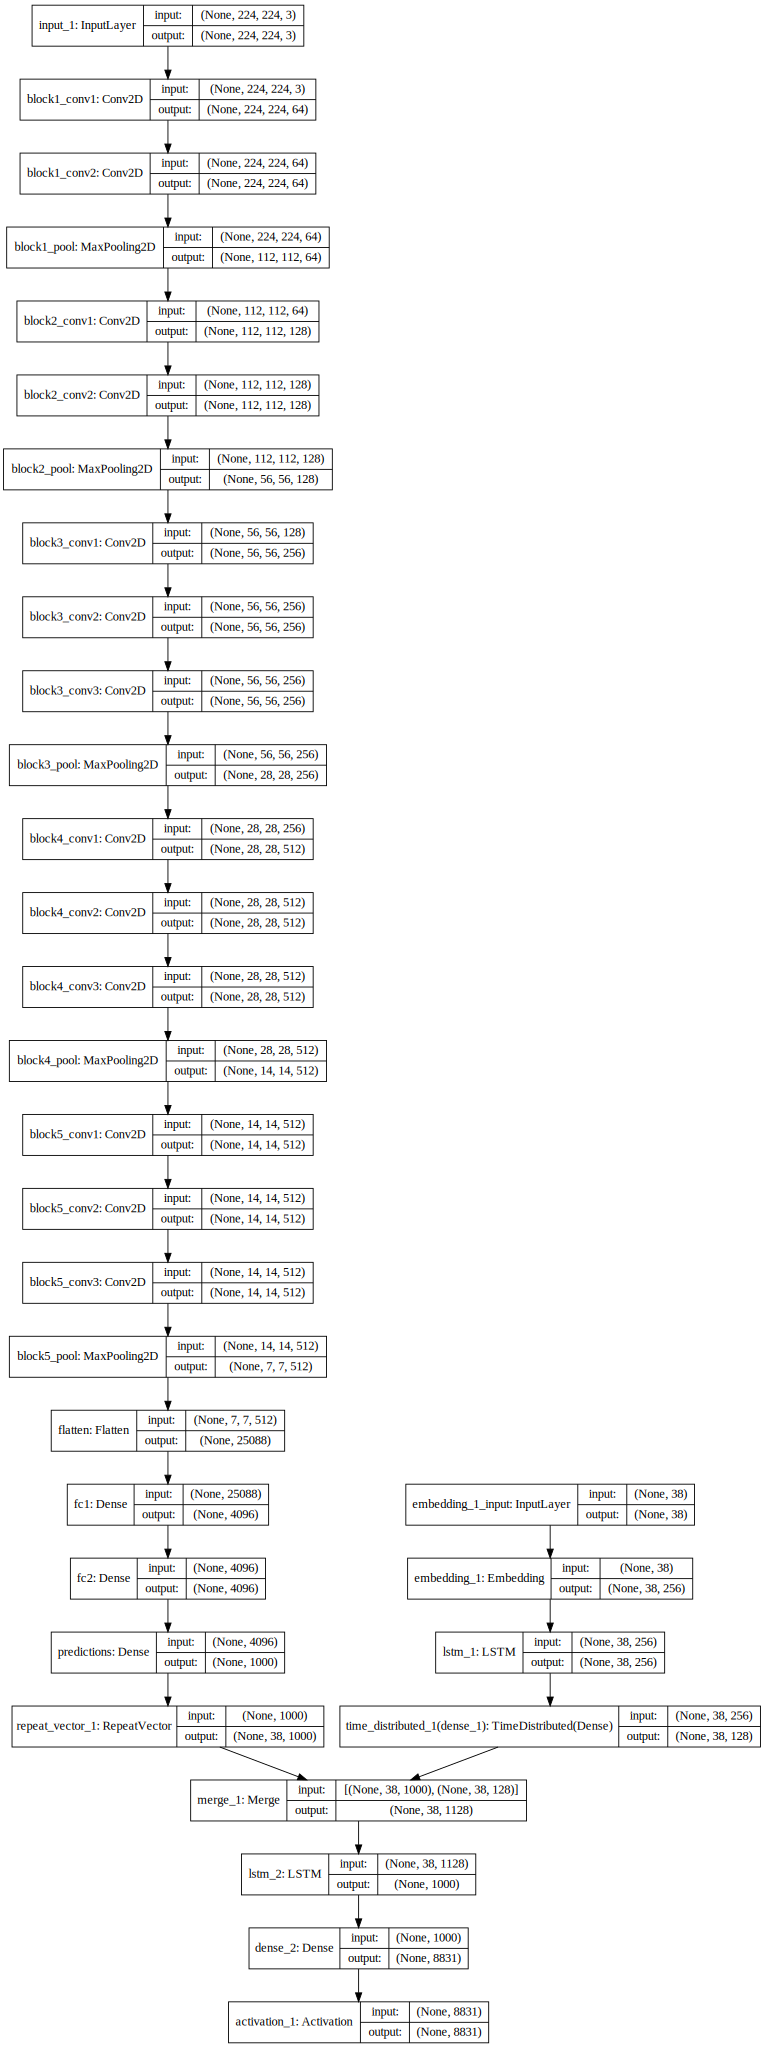

In [8]:
# Change this to 256 if reducing the importance of image
# features.
minimise_image_features = -1
train_image_encoder = False
embedding_size = 256
langauge_lstm_size = 256
langauge_output_size = 128
main_lstm_size = 1000


# Add the feature extractor - Could try Inception/MobileNet
# with trainable weights!
base_model = VGG16(weights='imagenet', 
                   include_top=True, 
                   input_shape=(224, 224, 3))

# Get rid of the classification layer.
base_model.layers.pop() 
base_model.outputs = [base_model.layers[-1].output]
base_model.layers[-1].outbound_nodes = []
base_model.trainable = train_image_encoder

# The image encoder.
image_model = Sequential()
image_model.add(base_model)
if minimise_image_features is not -1:
    image_model.add(Dense(embedding_size))
image_model.add(RepeatVector(max_caption_length))

# The text encoder.
language_model = Sequential()
language_model.add(Embedding(unique_words,
                             embedding_size, 
                             input_length=max_caption_length))
language_model.add(LSTM(langauge_lstm_size, return_sequences=True))
language_model.add(TimeDistributed(Dense(langauge_output_size)))

# The main model.
model = Sequential()
model.add(Merge([image_model, language_model], mode='concat'))
model.add(LSTM(main_lstm_size, return_sequences=False))
model.add(Dense(unique_words))
model.add(Activation('softmax'))  
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
def load_image(path):
    path = os.path.join('./Flicker8k_Dataset', path)
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.asarray(x)


class DataGenerator():
    
    
    def __init__(self, partial_sentances, images, next_words, vocab_size):
        self.images = np.array(images)
        self.partial_sentances = np.array(partial_sentances) 
        self.next_words = np.array(next_words)
        assert len(self.images) == len(self.partial_sentances)
        assert len(self.next_words) == len(self.images)
        self.data_size = len(self.images)
        self.vocab_size = vocab_size
        
        
    def data_generator(self, batch_size, shuffle=True):
        data_size = self.data_size
        while True:
            
            if shuffle:
                permutation = np.random.permutation(data_size)
                self.images = self.images[permutation]
                self.partial_sentances = self.partial_sentances[permutation]
                self.next_words = self.next_words[permutation]
            
            for start in range(data_size - batch_size):
                end = start + batch_size
                
                batch_image_paths = self.images[start:end]
                batch_next_words = self.next_words[start:end]
                batch_partial_sentances = self.partial_sentances[start:end]
                
                batch_images = np.array([load_image(image) 
                                         for image in batch_image_paths])
                batch_x = [batch_images, batch_partial_sentances]
                batch_y = np.zeros((batch_size, self.vocab_size))
                
                for i, next_word in enumerate(batch_next_words):
                    batch_y[i][next_word] = 1.0
                    
                yield [batch_x, batch_y]
                
                
partial_sentances, images, next_words = zip(*train_set)
data_gen = DataGenerator(partial_sentances, 
                         images, 
                         next_words, 
                         unique_words)

In [ ]:
batch_size = 64
epochs = 50

file_name = 'weights-improvement-{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(file_name, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

callbacks_list = [checkpoint]
model.fit_generator(data_gen.data_generator(batch_size), 
                    steps_per_epoch=data_gen.data_size / batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    callbacks=callbacks_list)


Epoch 1/50
   7/5056 [..............................] - ETA: 385419s - loss: 5.3565 - acc: 0.1272